# Plot maps of sea ice

CM2-025, CM2-1, OM2-025, OM2-1, observations

In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cmocean as cm
import cosima_cookbook as cc

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client

client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37271,Workers: 28
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:39179,Total threads: 1
Dashboard: /proxy/46709/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:41999,


#### Define a few things first

In [3]:
# Path to data
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'
path_to_data_cz861 = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025_cz861/'

In [4]:
# Plotting info
ft_size = 12
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [6]:
# Define colours
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

In [5]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

### Grid information

In [7]:
area_t025 = cc.querying.getvar(expt_OM2_025, 'area_t', session_OM2, n=1)
area_t1   = cc.querying.getvar(expt_OM2_1, 'area_t', session_OM2, n=1)

In [8]:
geolon_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t025 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [9]:
geolon_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolon_t
geolat_t1 = xr.open_dataset('/g/data/ik11/grids/ocean_grid_10.nc').geolat_t

### Observations

Sea ice concentration is previously interpolated onto OM2 grid in `Calc_NSIDC_sic_onto_OM2_grid.ipynb`.

In [10]:
NH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_NH_grid_OM2_025.nc')
SH_sic_obs = xr.open_dataarray('/g/data/x77/wgh581/Post_Process/Observations/' + 'NSIDC_sic_1979_2019_monthly_SH_grid_OM2_025.nc')

Sea ice concentration in peak season

In [11]:
# # NH: March
# NH_sic_obs_Mar = NH_sic_obs[({"time": NH_sic_obs.time.dt.month == 3})]
# # SH: Sep
# SH_sic_obs_Sep = SH_sic_obs[({"time": SH_sic_obs.time.dt.month == 9})]

Monthly sic climatology all years

In [11]:
NH_sic_obs_clim = NH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(40, 90))
SH_sic_obs_clim = SH_sic_obs.groupby('time.month').mean('time',skipna=True).sel(yt_ocean=slice(-90, -40)) 

Monthly sea ice area/extend climatology, in km2

In [41]:
NH_sia_obs_clim = (NH_sic_obs_clim.where(NH_sic_obs_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
SH_sia_obs_clim = (SH_sic_obs_clim.where(SH_sic_obs_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6

In [ ]:
NH_sia_obs_clim = NH_sia_obs_clim.load()
SH_sia_obs_clim = SH_sia_obs_clim.load()

Mean, max, min sea ice extent

In [43]:
print('Antarctic')
print('mean =', np.round(SH_sia_obs_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(SH_sia_obs_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(SH_sia_obs_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('Arctic')
print('mean =', np.round(NH_sia_obs_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(NH_sia_obs_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(NH_sia_obs_clim.min().values*1e-6,2), '10^6 km^2')

Antarctic
mean = 9.33 10^6 km^2
max = 15.78 10^6 km^2
min = 1.83 10^6 km^2

Arctic
mean = 9.31 10^6 km^2
max = 12.62 10^6 km^2
min = 5.05 10^6 km^2


**I haven't detrended the sea ice observations**

For NH, change the lat, lon values (rotated pole)

In [15]:
NH_sic_obs_clim = NH_sic_obs_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})

### Model sea ice

Load sea ice concentration climatology (calculated further down in this script).

In [16]:
aice_CM2_025_NH_clim = xr.open_dataarray(path_to_data_cz861 + 'aice_CM2_025_NH_clim_400_499_cz861.nc')
aice_CM2_025_SH_clim = xr.open_dataarray(path_to_data_cz861 + 'aice_CM2_025_SH_clim_400_499_cz861.nc')

In [17]:
aice_OM2_025_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_NH_clim_2300_2399.nc')
aice_OM2_025_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_025/aice_OM2_025_SH_clim_2300_2399.nc')

In [18]:
aice_OM2_1_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_NH_clim_2300_2399.nc')
aice_OM2_1_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_OM2_1/aice_OM2_1_SH_clim_2300_2399.nc')

In [19]:
aice_CM2_1_NH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_NH_clim_400_499.nc')
aice_CM2_1_SH_clim = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/aice_CM2_1_SH_clim_400_499.nc')

In [65]:
# test.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
# test.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

For NH, change the lat, lon values (rotated pole)

In [20]:
aice_CM2_025_NH_clim = aice_CM2_025_NH_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
aice_CM2_1_NH_clim   = aice_CM2_1_NH_clim.assign_coords({'geolon_t': geolon_t1, 'geolat_t': geolat_t1})
aice_OM2_025_NH_clim = aice_OM2_025_NH_clim.assign_coords({'geolon_t': geolon_t025, 'geolat_t': geolat_t025})
aice_OM2_1_NH_clim   = aice_OM2_1_NH_clim.assign_coords({'geolon_t': geolon_t1, 'geolat_t': geolat_t1})

In [21]:
# Above code doesn't properly work for CM2-1 abd OM2-1 (gives nans only), assign geolon_t, geolat_t values per hand
aice_CM2_1_NH_clim.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
aice_CM2_1_NH_clim.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

aice_OM2_1_NH_clim.geolat_t.values = geolat_t1.sel(yt_ocean=slice(40,90))
aice_OM2_1_NH_clim.geolon_t.values = geolon_t1.sel(yt_ocean=slice(40,90))

Get sea ice extent

In [ ]:
sie_CM2_025_NH_clim = (aice_CM2_025_NH_clim.where(aice_CM2_025_NH_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_025_SH_clim = (aice_CM2_025_SH_clim.where(aice_CM2_025_SH_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_025_NH_clim = sie_CM2_025_NH_clim.load()
sie_CM2_025_SH_clim = sie_CM2_025_SH_clim.load()

In [45]:
sie_CM2_1_NH_clim = (aice_CM2_1_NH_clim.where(aice_CM2_1_NH_clim>=0.15,0) * area_t1.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_1_SH_clim = (aice_CM2_1_SH_clim.where(aice_CM2_1_SH_clim>=0.15,0) * area_t1.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_CM2_1_NH_clim = sie_CM2_1_NH_clim.load()
sie_CM2_1_SH_clim = sie_CM2_1_SH_clim.load()

In [ ]:
sie_OM2_025_NH_clim = (aice_OM2_025_NH_clim.where(aice_OM2_025_NH_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_025_SH_clim = (aice_OM2_025_SH_clim.where(aice_OM2_025_SH_clim>=0.15,0) * area_t025.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_025_NH_clim = sie_OM2_025_NH_clim.load()
sie_OM2_025_SH_clim = sie_OM2_025_SH_clim.load()

In [47]:
sie_OM2_1_NH_clim = (aice_OM2_1_NH_clim.where(aice_OM2_1_NH_clim>=0.15,0) * area_t1.sel(yt_ocean=slice(40, 90))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_1_SH_clim = (aice_OM2_1_SH_clim.where(aice_OM2_1_SH_clim>=0.15,0) * area_t1.sel(yt_ocean=slice(-90, -40))).sum('xt_ocean').sum('yt_ocean') * 1e-6
sie_OM2_1_NH_clim = sie_OM2_1_NH_clim.load()
sie_OM2_1_SH_clim = sie_OM2_1_SH_clim.load()

In [48]:
print('CM2-025')
print('Antarctic')
print('mean =', np.round(sie_CM2_025_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_025_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_025_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_CM2_025_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_025_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_025_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('CM2-1')
print('Antarctic')
print('mean =', np.round(sie_CM2_1_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_1_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_1_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_CM2_1_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_CM2_1_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_CM2_1_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('OM2-025')
print('Antarctic')
print('mean =', np.round(sie_OM2_025_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_025_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_025_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_OM2_025_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_025_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_025_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')
print('OM2-1')
print('Antarctic')
print('mean =', np.round(sie_OM2_1_SH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_1_SH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_1_SH_clim.min().values*1e-6,2), '10^6 km^2')
print('Arctic')
print('mean =', np.round(sie_OM2_1_NH_clim.mean().values*1e-6,2), '10^6 km^2')
print('max =', np.round(sie_OM2_1_NH_clim.max().values*1e-6,2), '10^6 km^2')
print('min =', np.round(sie_OM2_1_NH_clim.min().values*1e-6,2), '10^6 km^2')
print('')

CM2-025
Antarctic
mean = 6.58 10^6 km^2
max = 12.38 10^6 km^2
min = 0.1 10^6 km^2
Arctic
mean = 9.83 10^6 km^2
max = 14.64 10^6 km^2
min = 3.77 10^6 km^2

CM2-1
Antarctic
mean = 7.78 10^6 km^2
max = 14.0 10^6 km^2
min = 0.4 10^6 km^2
Arctic
mean = 10.82 10^6 km^2
max = 15.56 10^6 km^2
min = 4.86 10^6 km^2

OM2-025
Antarctic
mean = 9.75 10^6 km^2
max = 15.66 10^6 km^2
min = 0.73 10^6 km^2
Arctic
mean = 10.37 10^6 km^2
max = 14.28 10^6 km^2
min = 4.91 10^6 km^2

OM2-1
Antarctic
mean = 8.87 10^6 km^2
max = 14.8 10^6 km^2
min = 0.51 10^6 km^2
Arctic
mean = 10.45 10^6 km^2
max = 14.54 10^6 km^2
min = 4.7 10^6 km^2



### Plotting

### Monthly climatology

In [27]:
month_label = ['J','F','M','A','M','J','J','A','S','O','N','D']

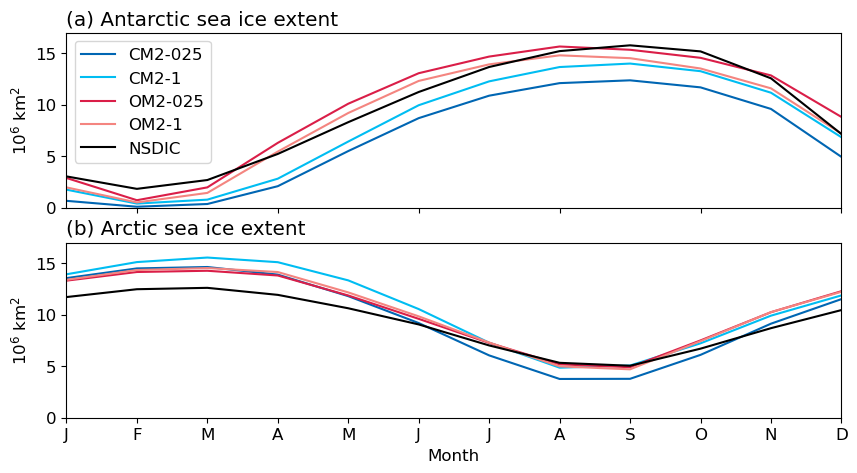

In [49]:
fig = plt.figure(figsize=(10,5))

plt.subplot(211)
(sie_CM2_025_SH_clim*1e-6).plot(label='CM2-025', color=CLEX_CobaldBlue)
(sie_CM2_1_SH_clim*1e-6).plot(label='CM2-1', color=CLEX_SkyBlue)
(sie_OM2_025_SH_clim*1e-6).plot(label='OM2-025', color=CLEX_Red)
(sie_OM2_1_SH_clim*1e-6).plot(label='OM2-1', color=CLEX_Pink)
(SH_sia_obs_clim*1e-6).plot(label='NSDIC', color='k')
plt.legend(ncol=1, fontsize=ft_size)
plt.xlim(1,12)
plt.ylim(0, 17)
plt.title('(a) Antarctic sea ice extent', loc='left')
plt.xlabel('')
plt.ylabel('10$^{6}$ km$^{2}$')
#plt.xticks(ticks=np.arange(1,13,1), labels=month_label)
plt.tick_params(labelbottom=False)

plt.subplot(212)
(sie_CM2_025_NH_clim*1e-6).plot(label='CM2-025, NH', color=CLEX_CobaldBlue)
(sie_CM2_1_NH_clim*1e-6).plot(label='CM2-1, NH', color=CLEX_SkyBlue)
(sie_OM2_025_NH_clim*1e-6).plot(label='OM2-025, NH', color=CLEX_Red)
(sie_OM2_1_NH_clim*1e-6).plot(label='OM2-1, NH', color=CLEX_Pink)
(NH_sia_obs_clim*1e-6).plot(label='NSDIC, NH', color='k')
plt.xlim(1,12)
plt.ylim(0, 17)
plt.title('(b) Arctic sea ice extent', loc='left')
plt.xlabel('Month')
plt.ylabel('10$^{6}$ km$^{2}$')
plt.xticks(ticks=np.arange(1,13,1), labels=month_label)

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig8_sie_climatology_maps_cz861.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');

### Circumpolar map

In [32]:
import matplotlib.path as mpath

theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5#0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [33]:
# Use cartopy land for now (option to update to model land but will change with resolution)
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='darkgrey', linewidth=0.5)

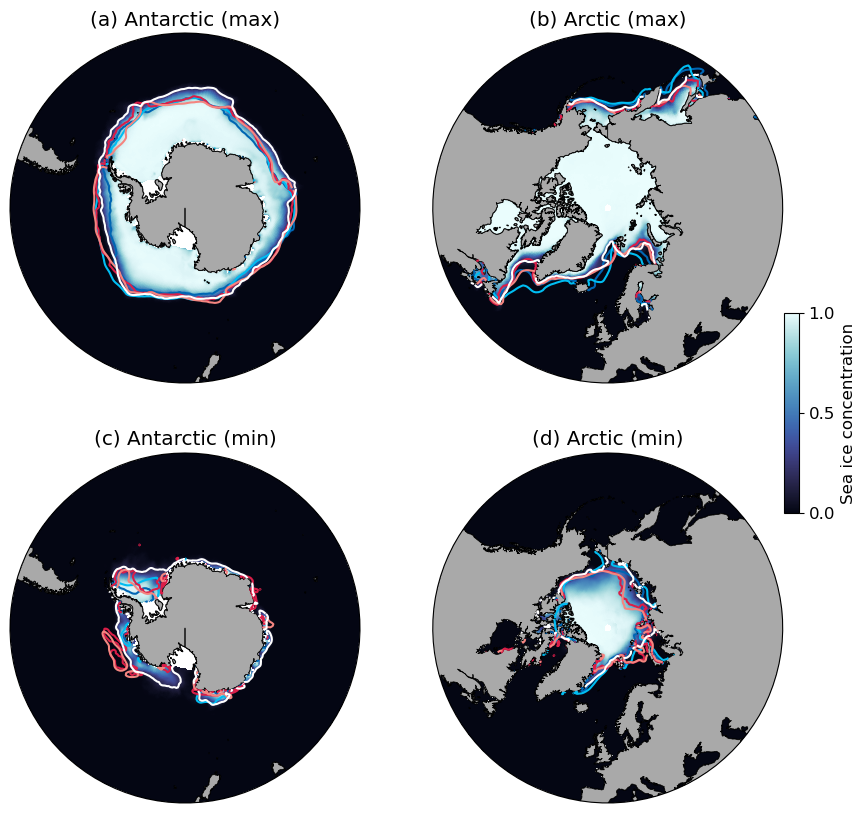

In [35]:
fig = plt.figure(figsize=(10,10))

#gs  = gridspec.GridSpec(6, 43, width_ratios=[1, 1, 0.05])#, hspace=0.2, wspace=0.15)

# a) Antarctic, max
ax = plt.subplot(2,2,1, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
sc = SH_sic_obs_clim[8,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
aice_CM2_025_SH_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_SH_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_SH_clim[7,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_SH_clim[7,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
SH_sic_obs_clim[8,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('(a) Antarctic (max)')

# b) Arctic, max
ax = plt.subplot(2,2,2, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
NH_sic_obs_clim[2,...].plot.pcolormesh(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
aice_CM2_025_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_NH_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
NH_sic_obs_clim[2,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('(b) Arctic (max)')

# c) Antarctic, min
ax = plt.subplot(2,2,3, projection=ccrs.SouthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
SH_sic_obs_clim[1,...].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
aice_CM2_025_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_SH_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
SH_sic_obs_clim[1,...].plot.contour(transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('(c) Antarctic (min)')

# d) Arctic, min
ax = plt.subplot(2,2,4, projection=ccrs.NorthPolarStereo())
ax.set_boundary(circle, transform=ax.transAxes)
NH_sic_obs_clim[8,...].plot.pcolormesh(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), cmap=cm.cm.ice, vmin=0, vmax=1, add_colorbar=False)
aice_CM2_025_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_CobaldBlue)
aice_CM2_1_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_SkyBlue)
aice_OM2_025_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Red)
aice_OM2_1_NH_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors=CLEX_Pink)
NH_sic_obs_clim[8,...].plot.contour(x='geolon_t', y='geolat_t', transform=ccrs.PlateCarree(), levels=[0.15], colors='w')
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
plt.title('(d) Arctic (min)')

# Colorbar
cbar_ax = fig.add_axes([0.9, 0.4, 0.015, 0.2])
cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(0,1.1,0.5))
cbar.set_label('Sea ice concentration')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig9_sie_maps_cz861.png'
    plt.savefig(fig_path + fig_name, dpi=300, bbox_inches='tight', facecolor='white');